# Optimización de funciones mediante un algoritmo genético

In [1]:
import numpy as np
import pylab as pl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import random

from deap import base, creator, tools

import elitism
import time

### Usaremos una función de prueba, con una cantidad de óptimos que depende de un parametro entero $n$.
Cuando cambiamos $n$ cambia la posición del óptimo global y suele haber más de uno.

\begin{equation}
f(x,y) = \Big(16x(1-x)y(1-y)\sin(n\pi x)\sin(n\pi y)\Big)^2
\end{equation}

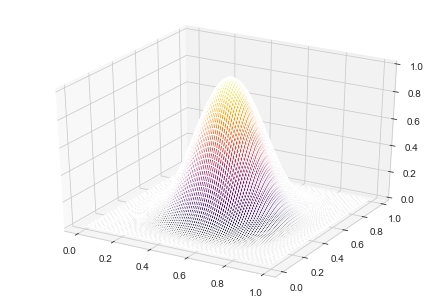

In [24]:
fig = pl.figure()
ax = Axes3D(fig)
X = np.arange(0., 1., 0.01)
Y = np.arange(0., 1., 0.01)
X, Y = np.meshgrid(X, Y)

n=1  # Hacer pruebas cambiando este parámetro.
Z = (16*X*(1 - X)*Y*(1 - Y)*np.sin(n*np.pi*X)*np.sin(n*np.pi*Y))**2

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='inferno')
ax.contourf(X, Y, Z, zdir='z', offset=-2, cmap='hot')
ax.set_zlim(0., 1)

pl.show()

## Aquí preparamos el algoritmo genético.

Empezamos con las constantes del problema:

In [3]:
DIMENSIONS = 2  # número de dimensiones
BOUND_LOW, BOUND_UP = 0.0, 1.0  # fronteras: las mismas para todas las variables

Y los parámetros del algoritmo:

In [4]:
POPULATION_SIZE = 20
P_CROSSOVER = 0.5  # probabilidad de cruza
P_MUTATION = 0.3   # probabilidad de mutación individual: máximo 0.5 o el AG se vuelve una búsqueda aleatoria.
MAX_GENERATIONS = 50  # esto funciona como una condición de terminación del AG
HALL_OF_FAME_SIZE = 2  # soluciones que pasan a la siguiente generación sin ser alteradas: elitismo.
CROWDING_FACTOR = 20.0  # factor de balance entre las cruza y la probabilidad

In [5]:
# semilla de números aleatorios:
#RANDOM_SEED = 42
#random.seed(RANDOM_SEED)

Toolbox es el objeto principal de la librería DEAP, todo lo demas son modificaciones al código base.

In [6]:
toolbox = base.Toolbox()

Por ser modificaciones a las clases del toolbox, cada vez que se ejecuten las instrucciones se reescribirán las clases, 
lo cual puede producir errores de memoria. Se aconseja ejecutar las siguientes instrucciones solo una vez y 
solo ajustar los cambios de tipo de optimización: maximización o minimización y la función de prueba, de ser necesario.

Aquí se define la estrategia a implementar: maximizar o minimizar la función:

In [7]:
#creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # para minimizar
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # para maximizar

Se crean los individuos o posibles soluciones:

In [8]:
#creator.create("Individual", list, fitness=creator.FitnessMin) # para minimizar
creator.create("Individual", list, fitness=creator.FitnessMax) # para maximizar

Aquí se crean números aleatorios en cajas $n$-dimensionales, donde $n$ es el número de variables del problema.

In [9]:
def randomFloat(low, up):
    return [random.uniform(l, u) for l, u in zip([low] * DIMENSIONS, [up] * DIMENSIONS)]

Los números aleatorios se transforman en números decimales dentro de las fronteras del problema:

In [10]:
toolbox.register("attrFloat", randomFloat, BOUND_LOW, BOUND_UP)

Los números anteriores su usan para formar las posibles soluciones (individuos) y estos se agrupan para formar
una población.

In [11]:
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.attrFloat) # crea individuos

toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator) # crea y guarda la población

### En este punto se define la función de prueba.
Puede definirse desde antes, pero aquí debe ser invocada e incorporada al toolbox.

In [25]:
def charbonneau(individual):
    x = individual[0]
    y = individual[1]
    n = 1

    f = (16*x*(1 - x)*y*(1 - y)*np.sin(n*np.pi*x)*np.sin(n*np.pi*y))**2
    return f,  # return a tuple

toolbox.register("evaluate", charbonneau) # envia la evaluación de la función (fitness) al registro histórico

### Aquí se introduce el ciclo principal del algoritmo genético.
Se definen los operadores genéticos: seleccion, cruza y mutación.

In [13]:
toolbox.register("select", tools.selTournament, tournsize=2)
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUND_LOW, up=BOUND_UP, eta=CROWDING_FACTOR, 
                 indpb=1.0/DIMENSIONS)

Y se preparan el ciclo principal del algoritmo genético.

In [14]:
def main():

    population = toolbox.populationCreator(n=POPULATION_SIZE) # crea la generación inicial

    stats = tools.Statistics(lambda ind: ind.fitness.values) # prepara el registro estadístico histórico
    #stats.register("min", np.min) # para minimizar
    stats.register("max", np.max)  # para maximizar
    stats.register("avg", np.mean) # guarda el valor promedio

    hof = tools.HallOfFame(HALL_OF_FAME_SIZE) # define el tamaño del salón de la fama

    # aquí introduce el elitismo:
    population, logbook = elitism.eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                              ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=True)

    # imprime la mejor solución:
    best = hof.items[0]
    print("-- Best Individual = ", best)
    print("-- Best Fitness = ", best.fitness.values[0])

    minFitnessValues, meanFitnessValues = logbook.select("max", "avg") # recupera las estadísticas.

    # grafica la evolución del algoritmo:
    sns.set_style("whitegrid")
    plt.plot(minFitnessValues, color='red')
    plt.plot(meanFitnessValues, color='green')
    plt.xlabel('Generation')
    plt.ylabel('Max / Average Fitness')
    plt.title('Max and Average fitness over Generations')

    plt.show()
    
    return best

gen	nevals	max     	avg     
0  	20    	0.885321	0.189058
1  	11    	0.889228	0.471606
2  	13    	0.897412	0.644009
3  	12    	0.933891	0.833242
4  	14    	0.936354	0.897645
5  	14    	0.936354	0.908251
6  	11    	0.969444	0.912568
7  	14    	0.973645	0.90053 
8  	9     	0.992839	0.939091
9  	12    	0.992839	0.953949
10 	12    	0.992839	0.972859
11 	10    	0.997129	0.974495
12 	14    	0.997232	0.939904
13 	10    	0.997331	0.979078
14 	16    	0.997344	0.963804
15 	11    	0.997344	0.973886
16 	11    	0.997344	0.956458
17 	12    	0.997346	0.964078
18 	10    	0.997865	0.967159
19 	9     	0.997865	0.983833
20 	6     	0.997865	0.988648
21 	11    	0.997865	0.996862
22 	12    	0.997867	0.957969
23 	12    	0.999686	0.935198
24 	10    	0.999686	0.971472
25 	10    	0.999686	0.984135
26 	16    	0.999686	0.977004
27 	13    	0.999686	0.985903
28 	8     	0.999686	0.986018
29 	11    	0.999686	0.988686
30 	15    	0.999778	0.999301
31 	14    	0.999778	0.983212
32 	11    	0.99978 	0.983408
33 	13    	0.9

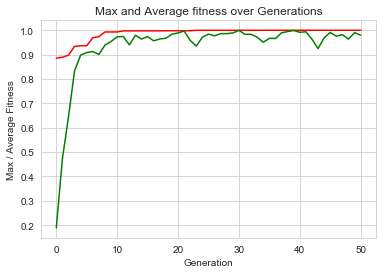

In [26]:
best_sol = main()

In [27]:
best_x, best_y = best_sol

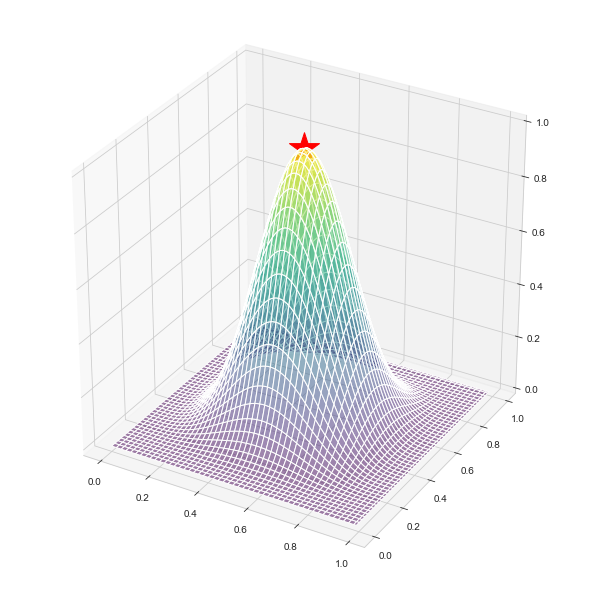

In [28]:
fig = pl.figure(figsize=(8, 8))
ax = Axes3D(fig)

X = np.arange(0., 1., 0.01)
Y = np.arange(0., 1., 0.01)
X, Y = np.meshgrid(X, Y)

#n=2  # Hacer pruebas cambiando este parámetro.
Z = (16*X*(1 - X)*Y*(1 - Y)*np.sin(n*np.pi*X)*np.sin(n*np.pi*Y))**2
best_z = (16*best_x*(1 - best_x)*best_y*(1 - best_y)*np.sin(n*np.pi*best_y)*np.sin(n*np.pi*best_y))**2

ax.scatter(best_x, best_y, best_z, marker='*', s=1000, c='red')

ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
ax.set_zlim(0., 1)

pl.show()